In [1]:
import numpy as np
import sys
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_cellwise_df_10samplesperfile, extract_noise
from extract_cell_timetrace import extract_cell_timetrace
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
data_path = 'C:/Users/vpming/tuni_ml/data'
df = build_cellwise_df_10samplesperfile(data_path)

In [ ]:
x = np.stack(df['time_trace'])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3
n_bins = 4
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [4]:
class MLP(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_timepoints, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [6]:
def fit(model, train_loader, test_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/mlp_dtt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/50 Train Loss: 0.8683  Train Accuracy: 59.54%  Test Loss: 0.9171  Test Accuracy: 57.73%
Epoch 10/50 Train Loss: 0.7867  Train Accuracy: 63.69%  Test Loss: 0.9739  Test Accuracy: 56.44%
Epoch 15/50 Train Loss: 0.6971  Train Accuracy: 68.13%  Test Loss: 1.0913  Test Accuracy: 54.67%
Epoch 20/50 Train Loss: 0.6248  Train Accuracy: 72.01%  Test Loss: 1.2040  Test Accuracy: 55.46%
Epoch 25/50 Train Loss: 0.5427  Train Accuracy: 75.96%  Test Loss: 1.3953  Test Accuracy: 55.24%
Epoch 30/50 Train Loss: 0.4850  Train Accuracy: 78.68%  Test Loss: 1.6381  Test Accuracy: 53.60%
Epoch 35/50 Train Loss: 0.4466  Train Accuracy: 80.49%  Test Loss: 1.8111  Test Accuracy: 53.97%
Epoch 40/50 Train Loss: 0.3931  Train Accuracy: 83.10%  Test Loss: 1.9825  Test Accuracy: 52.97%
Epoch 45/50 Train Loss: 0.3639  Train Accuracy: 84.30%  Test Loss: 2.1708  Test Accuracy: 52.36%
Epoch 50/50 Train Loss: 0.3345  Train Accuracy: 85.78%  Test Loss: 2.3728  Test Accuracy: 52.96%


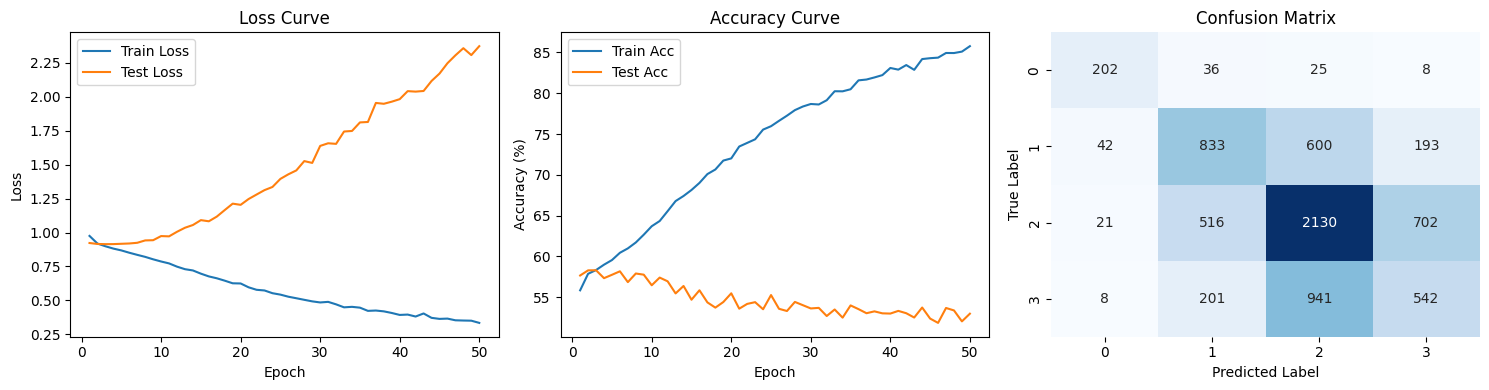

In [16]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = MLP(n_timepoints, n_classes)

fit(model, train_loader, test_loader)

In [20]:
cell_trace = extract_cell_timetrace('C:/Users/vpming/tuni_ml\data\stim_0.5_beta_0.04_noise_0.03_kcross_0.0050\sim_data__stimMag_0.50_beta_0.40_noise_0.030_kcross_0.0050_nSamples_1000_9.h5', 17)
cell_trace_scaled = x_scaler.transform(cell_trace.reshape(1, -1))
with torch.no_grad():
    logits = model(torch.tensor(cell_trace_scaled, dtype=torch.float32))
    pred_class = logits.argmax(dim=1).item()

print(pred_class)

2



=== Training for noise 0.01 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.7052  Train Accuracy: 67.24%  Test Loss: 0.8780  Test Accuracy: 58.60%
Epoch 10/15 Train Loss: 0.4998  Train Accuracy: 79.12%  Test Loss: 1.1001  Test Accuracy: 56.00%
Epoch 15/15 Train Loss: 0.2674  Train Accuracy: 90.31%  Test Loss: 1.4916  Test Accuracy: 54.75%


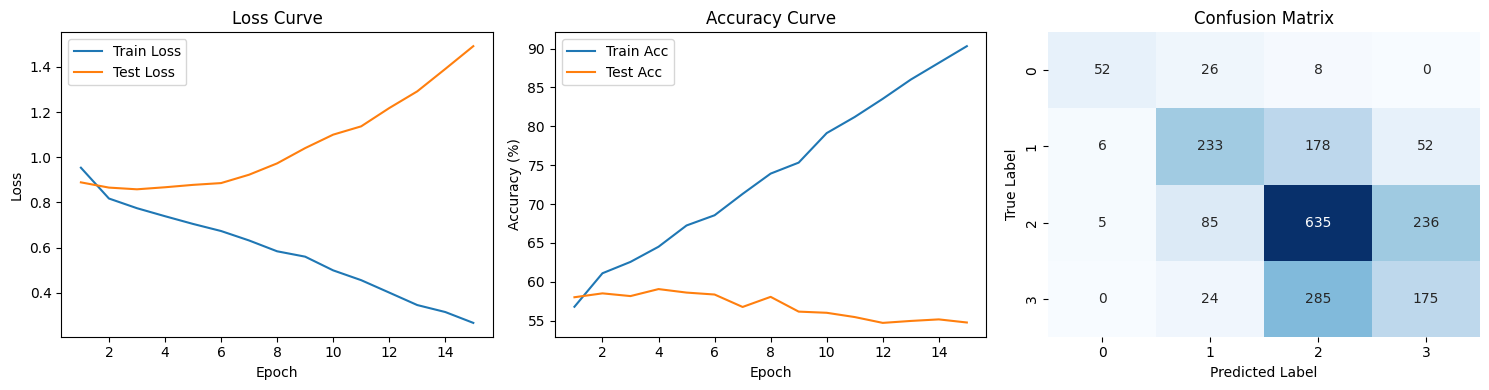


=== Training for noise 0.02 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.7822  Train Accuracy: 63.67%  Test Loss: 0.9832  Test Accuracy: 53.25%
Epoch 10/15 Train Loss: 0.5770  Train Accuracy: 75.11%  Test Loss: 1.1691  Test Accuracy: 53.70%
Epoch 15/15 Train Loss: 0.3223  Train Accuracy: 87.71%  Test Loss: 1.6139  Test Accuracy: 51.75%


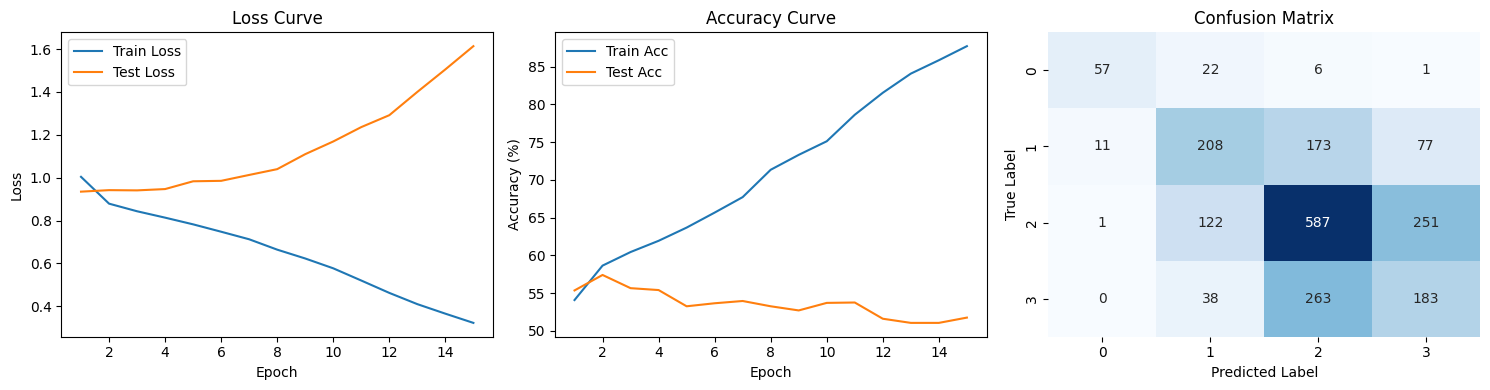


=== Training for noise 0.03 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.8377  Train Accuracy: 61.05%  Test Loss: 1.0104  Test Accuracy: 55.20%
Epoch 10/15 Train Loss: 0.6195  Train Accuracy: 74.33%  Test Loss: 1.2612  Test Accuracy: 52.05%
Epoch 15/15 Train Loss: 0.3652  Train Accuracy: 86.47%  Test Loss: 1.6216  Test Accuracy: 49.50%


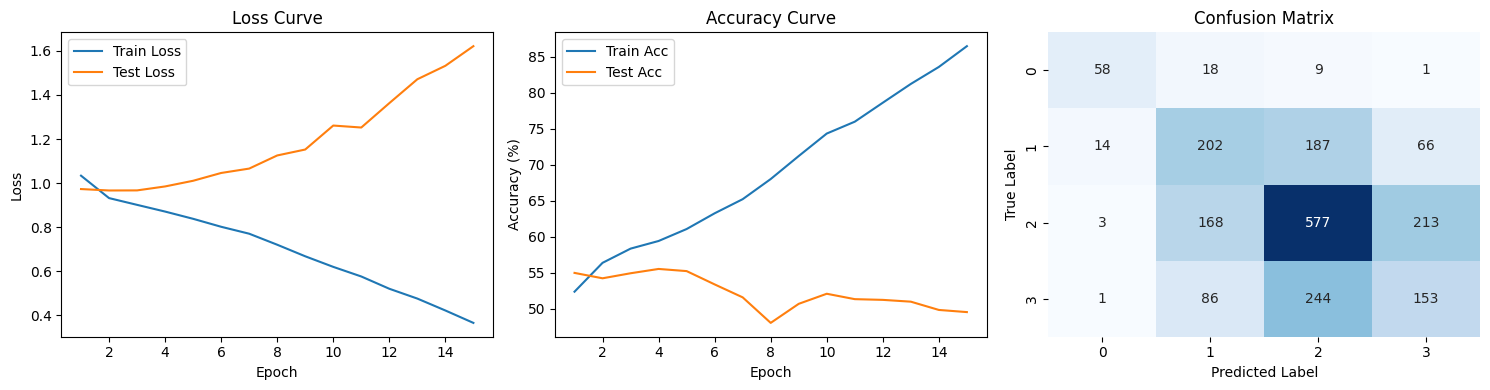


=== Training for noise 0.04 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.9002  Train Accuracy: 58.67%  Test Loss: 1.0560  Test Accuracy: 50.75%
Epoch 10/15 Train Loss: 0.6880  Train Accuracy: 70.47%  Test Loss: 1.3145  Test Accuracy: 47.60%
Epoch 15/15 Train Loss: 0.4379  Train Accuracy: 82.90%  Test Loss: 1.6378  Test Accuracy: 45.20%


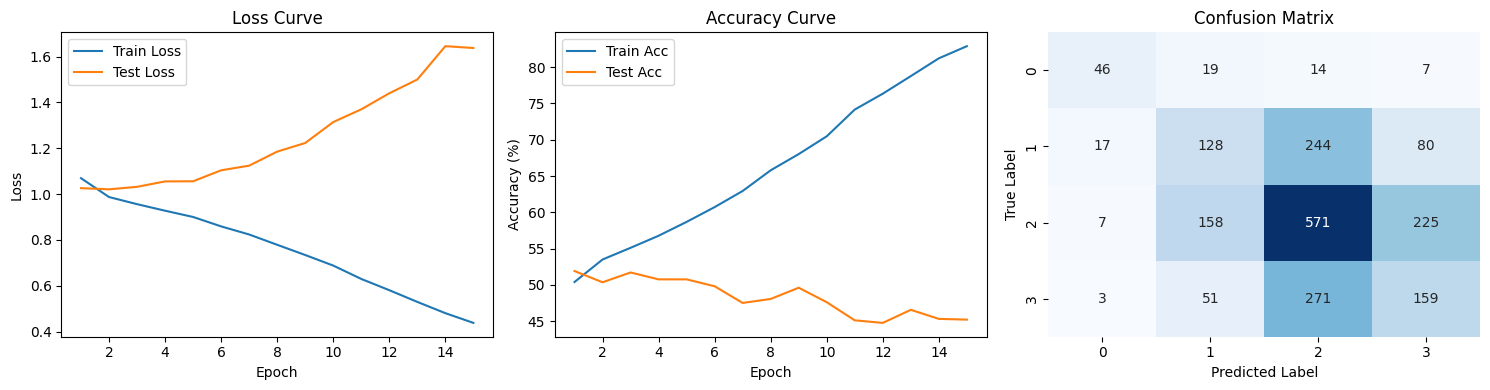


=== Training for noise 0.05 ===
Training on 8000 samples; Testing on 2000 samples
Epoch 5/15 Train Loss: 0.9357  Train Accuracy: 56.27%  Test Loss: 1.0817  Test Accuracy: 51.55%
Epoch 10/15 Train Loss: 0.7657  Train Accuracy: 66.15%  Test Loss: 1.2485  Test Accuracy: 46.30%
Epoch 15/15 Train Loss: 0.5585  Train Accuracy: 77.05%  Test Loss: 1.5721  Test Accuracy: 45.20%


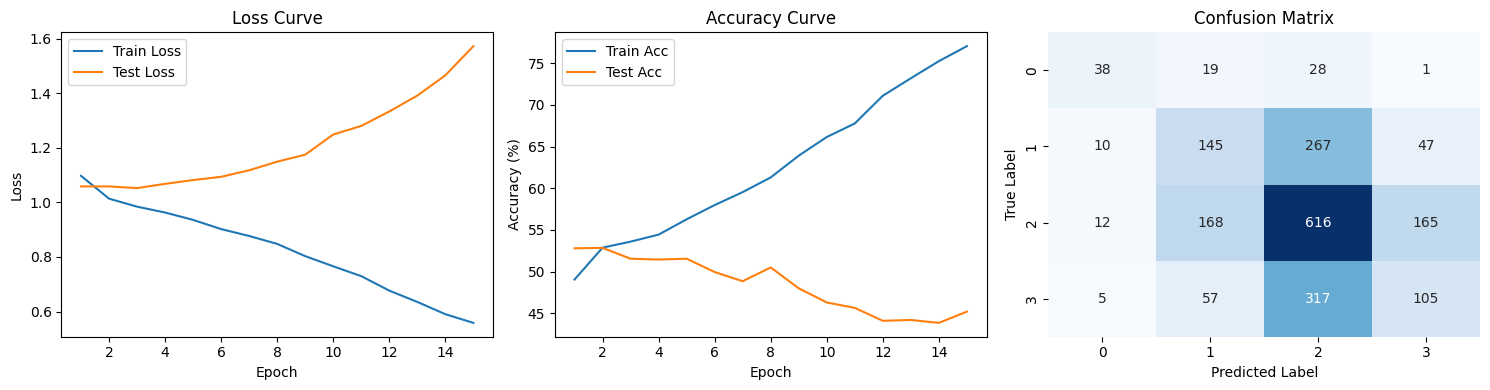

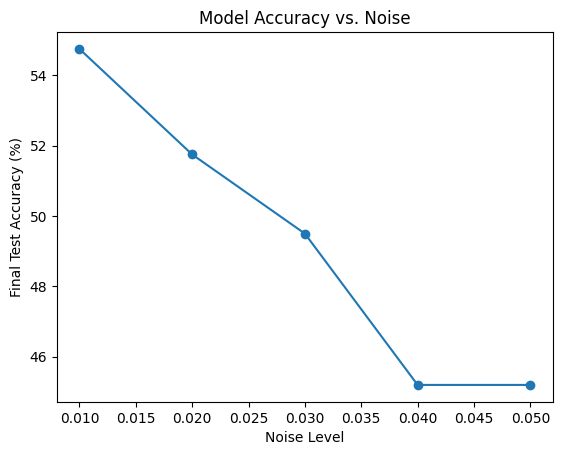

In [ ]:
df['noise'] = df['simulation_file'].apply(extract_noise)

results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    X = np.stack(df.loc[mask, 'time_trace'])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 4
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = MLP(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise")
plt.show()